In [14]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
DATASET_DIR = Path('/home/jovyan/jigsaw-toxic/data/datasets/wiki-talk-labels')

In [3]:
!ls -la $DATASET_DIR

total 102496
drwxr-xr-x  2 jovyan users     4096 Feb  6 16:12 .
drwxr-xr-x 14 jovyan users     4096 Feb  6 16:12 ..
-rw-r--r--  1 jovyan users 58121115 Feb  6 16:12 attack_annotated_comments.tsv
-rw-r--r--  1 jovyan users 46760112 Feb  6 16:12 attack_annotations.tsv
-rw-r--r--  1 jovyan users    57649 Feb  6 16:12 attack_worker_demographics.tsv


In [28]:
attack_annotated_comments_df = pd.read_csv(DATASET_DIR / 'attack_annotated_comments.tsv', sep='\t', header=0)
attack_annotations_df = pd.read_csv(DATASET_DIR / 'attack_annotations.tsv', sep='\t', header=0)
valid_df = pd.read_csv(DATASET_DIR / 'valid.csv')

In [29]:
valid_comment_set = set(valid_df['more_toxic'].unique()) | set(valid_df['less_toxic'].unique())

In [8]:
attack_annotated_comments_df

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...,...
115859,699848324,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...,2016,True,article,blocked,train
115860,699851288,NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...,2016,True,article,blocked,test
115861,699857133,NEWLINE_TOKEN:The way you're trying to describ...,2016,True,article,blocked,train
115862,699891012,NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...,2016,True,user,blocked,dev


In [9]:
attack_annotations_df

,rev_id,worker_id,quoting_attack,recipient_attack,third_party_attack,other_attack,attack
0,37675,1362,0.0,0.0,0.0,0.0,0.0
1,37675,2408,0.0,0.0,0.0,0.0,0.0
2,37675,1493,0.0,0.0,0.0,0.0,0.0
3,37675,1439,0.0,0.0,0.0,0.0,0.0
4,37675,170,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
1365212,699897151,628,0.0,0.0,0.0,0.0,0.0
1365213,699897151,15,0.0,0.0,0.0,0.0,0.0
1365214,699897151,57,0.0,0.0,0.0,0.0,0.0
1365215,699897151,1815,0.0,0.0,0.0,0.0,0.0


In [11]:
def generate_attack_df(comment_df: pd.DataFrame, annot_df: pd.DataFrame) -> pd.DataFrame:
    row_list = []
    for _, row in tqdm(comment_df.iterrows(), total=len(comment_df)):
        attack_score_arr = annot_df[annot_df['rev_id'] == row['rev_id']]['attack'].to_numpy()
        row_list.append({'comment_text': row['comment'], 'score': attack_score_arr.mean(), 'num_votes': len(attack_score_arr)})
    return pd.DataFrame(row_list)

In [12]:
attack_df = generate_attack_df(attack_annotated_comments_df, attack_annotations_df)

  0%|          | 0/115864 [00:00<?, ?it/s]

In [30]:
attack_df = attack_df[~attack_df['comment_text'].isin(valid_comment_set)]
attack_df

,comment_text,score,num_votes
0,`-NEWLINE_TOKENThis is not ``creative``. Thos...,0.000000,10
1,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,0.000000,9
2,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",0.000000,10
3,"Next, maybe you could work on being less cond...",0.444444,9
4,This page will need disambiguation.,0.000000,9
...,...,...,...
115859,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...,0.111111,9
115860,NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...,0.100000,10
115861,NEWLINE_TOKEN:The way you're trying to describ...,0.000000,9
115862,NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...,0.200000,10


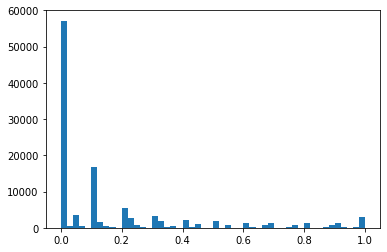

In [31]:
plt.hist(attack_df['score'], bins=50);

In [32]:
attack_subsampled_df = pd.concat([
    attack_df[attack_df['score'] > 0.0],
    attack_df[attack_df['score'] == 0.0].sample(n=10000),
]).reset_index(drop=True)

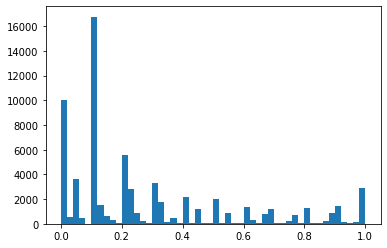

In [33]:
plt.hist(attack_subsampled_df['score'], bins=50);

In [38]:
attack_subsampled_df.to_csv(DATASET_DIR / 'train_reg.csv', index=False)

In [39]:
train_comment_set = set(attack_subsampled_df['comment_text'].unique())
len(train_comment_set & valid_comment_set)

0